## Population Disaggregation 

In [2]:
%load_ext autoreload
%autoreload 2
import os
import json
import rasterio
import numpy as np
import pickle
import pandas as pd
import geopandas
import xarray
import matplotlib.pyplot as plt
import shapely
from to_degree import to_degree
from region_new import Region
from region_new.region import regions_from_cities
from region_new.equations import *

In [3]:
# bounding boxes and FUA's
bounding_box = json.load(open('bounding_box.json'))
# MS buildings for each city
ordu_house = os.path.join("data","ml","prediction", "type", "Ordu.pkl")
adana_house = os.path.join("data","ml","prediction", "type", "Adana.pkl")
manisa_house = os.path.join("data","ml","prediction", "type", "Manisa.pkl")
trabzon_house = os.path.join("data","ml","prediction", "type", "Trabzon.pkl")

In [4]:
cities = dict(
    Ordu = dict ( box= bounding_box['Ordu']['box'], fua= bounding_box['Ordu']['fua'], name= 'Ordu', house= ordu_house ),
    Adana = dict( box= bounding_box["Adana"]["box"], fua= bounding_box["Adana"]["fua"], name = "Adana", house = adana_house ),
    Manisa = dict( box= bounding_box["Manisa"]["box"], fua= bounding_box["Manisa"]["fua"], name = "Manisa", house = manisa_house ),
    Trabzon = dict( box= bounding_box["Trabzon"]["box"], fua= bounding_box["Trabzon"]["fua"], name = "Trabzon", house = trabzon_house )
)

## Population Disaggregation
We test two distributions against each other at various resolutions.  
We either disaggregate population given the building volume -- *area x density x height* --  
or given the building surface only -- *area x density*.

#### GHSL-POP vs POP_S / POP_V

500 

250 



<Figure size 640x480 with 0 Axes>

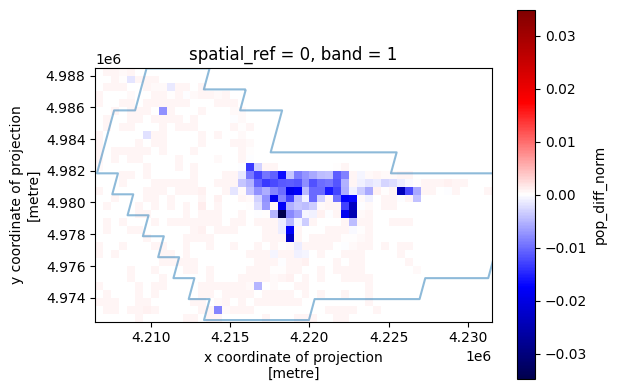

<Figure size 640x480 with 0 Axes>

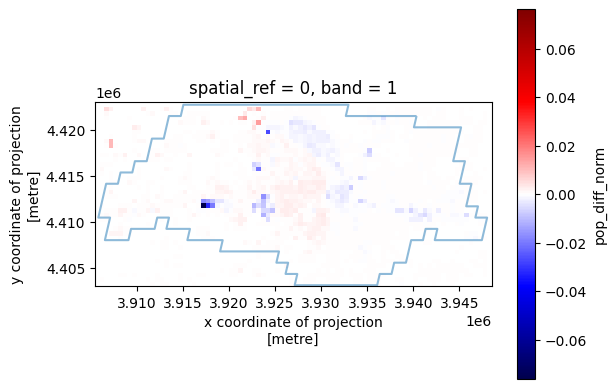

<Figure size 640x480 with 0 Axes>

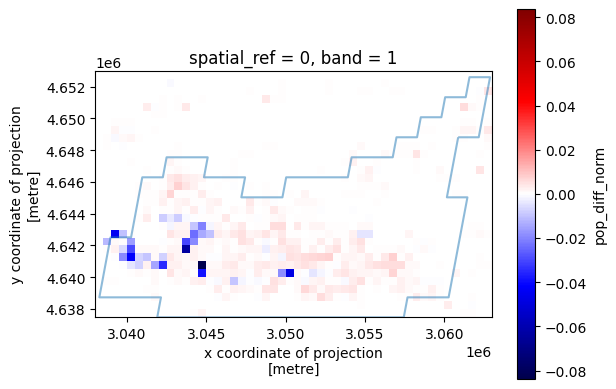

<Figure size 640x480 with 0 Axes>

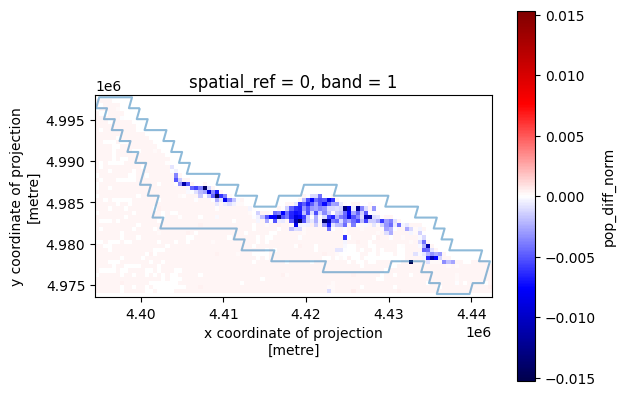

<Figure size 640x480 with 0 Axes>

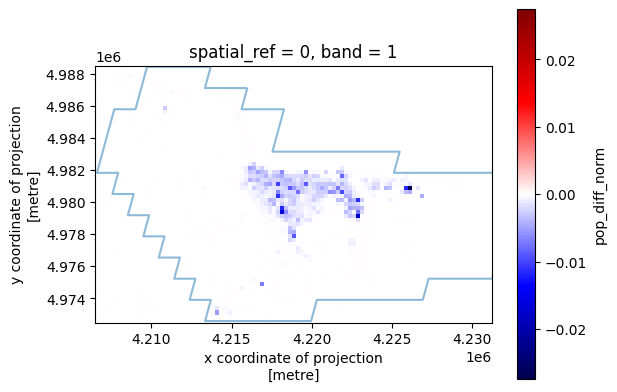

<Figure size 640x480 with 0 Axes>

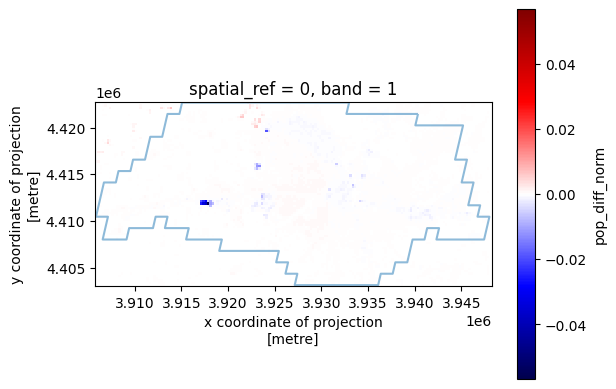

<Figure size 640x480 with 0 Axes>

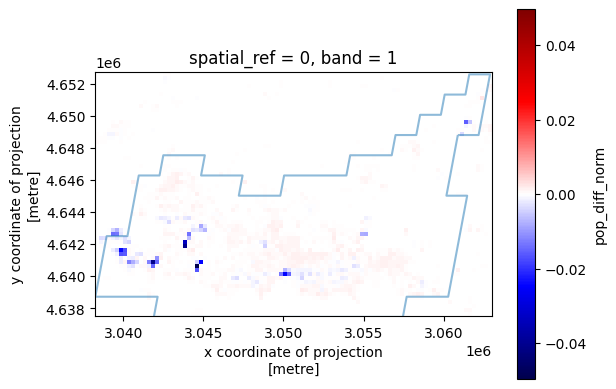

<Figure size 640x480 with 0 Axes>

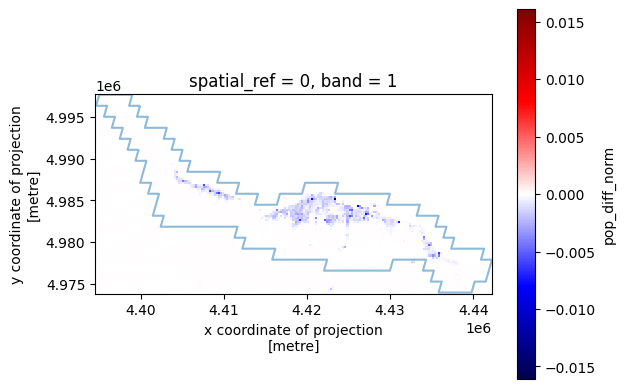

In [85]:
resolutions = [500, 250]
for r in resolutions:
    print(r, '\n')
    Cities = regions_from_cities(cities, r)
    for city in Cities:
        region = Cities[city]
        region.normalize_variable('ghsl_pop', output=True)
        region.normalize_variable('pop_v', output=True)
        region.output = region.output.assign(pop_diff_norm = region.output['ghsl_pop'] - region.output['pop_v'])
        # POP DIFF
        plt.figure()
        ax=region.vector['fua'].geo_df.exterior.plot(alpha=0.5)
        region.output['pop_diff_norm'].plot(ax=ax, cmap="seismic")

#### POP_S vs POP_v

500 

Ordu 500 828.0259951852898
Adana 500 2287.7857545932675
Manisa 500 3154.9759303910255
Trabzon 500 299.16267251339036
250 

Ordu 250 252.51190992850502
Adana 250 847.5505376873244
Manisa 250 1082.92328664041
Trabzon 250 78.43394777632551
100 

Ordu 100 46.36179010840187
Adana 100 160.08177034412884
Manisa 100 223.6214779813869


/tmp/ipykernel_47547/2095981379.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Trabzon 100 14.100172438043035
50 

Ordu 50 13.940982721550009
Adana 50 42.22087989516963
Manisa 50 69.11129639382754
Trabzon 50 4.063072549141254


<Figure size 640x480 with 0 Axes>

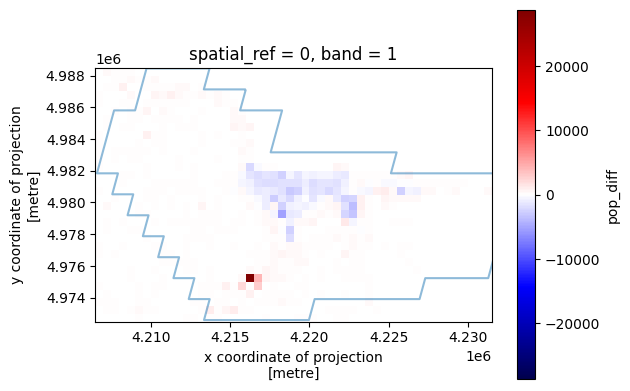

<Figure size 640x480 with 0 Axes>

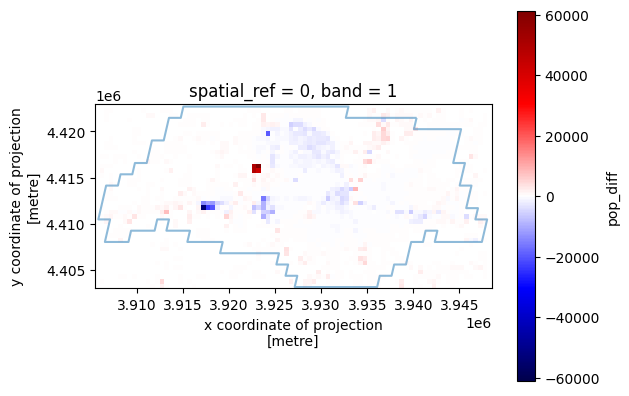

<Figure size 640x480 with 0 Axes>

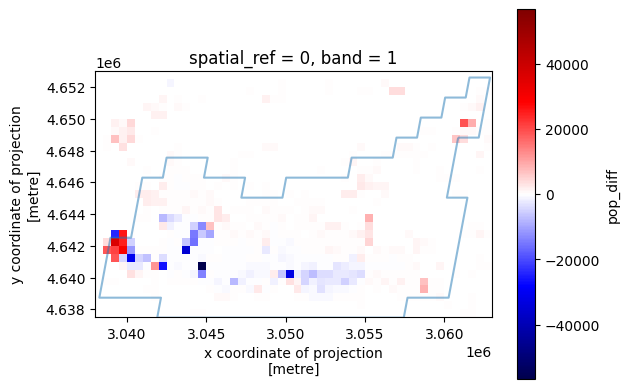

<Figure size 640x480 with 0 Axes>

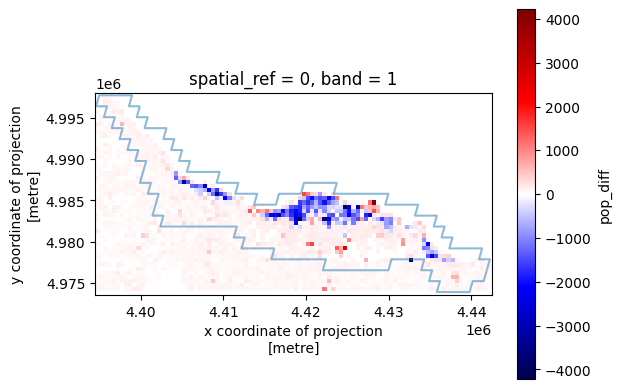

<Figure size 640x480 with 0 Axes>

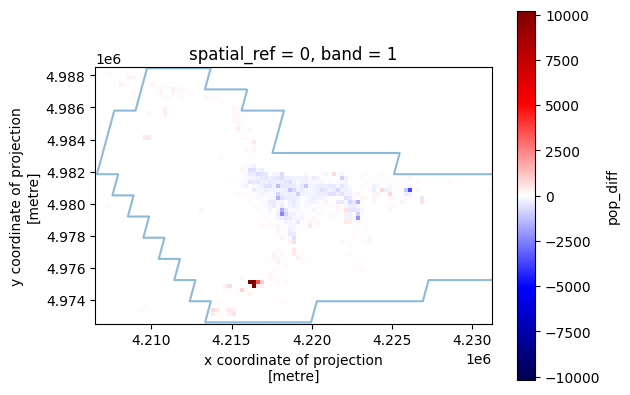

<Figure size 640x480 with 0 Axes>

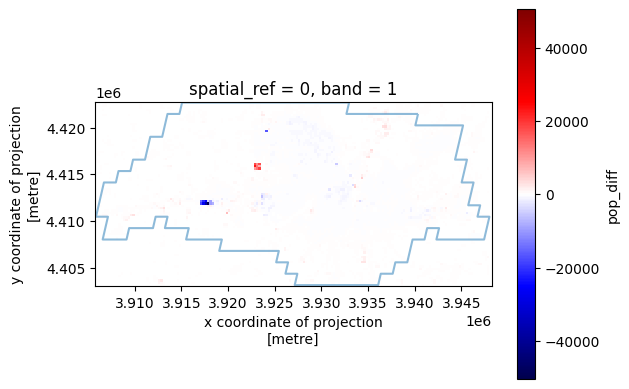

<Figure size 640x480 with 0 Axes>

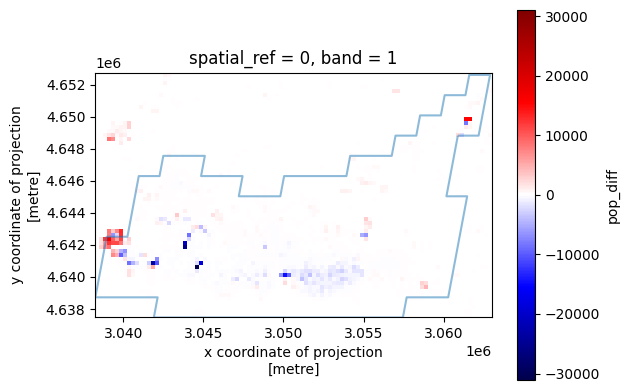

<Figure size 640x480 with 0 Axes>

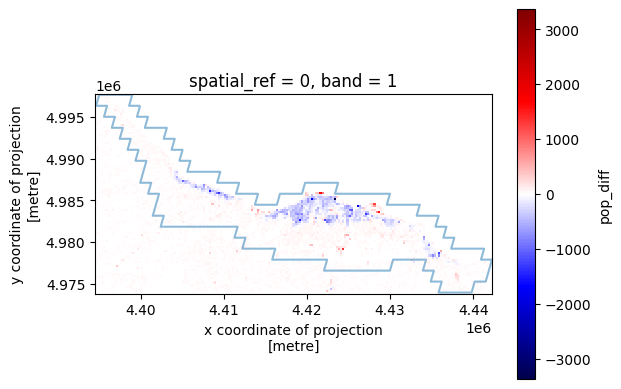

<Figure size 640x480 with 0 Axes>

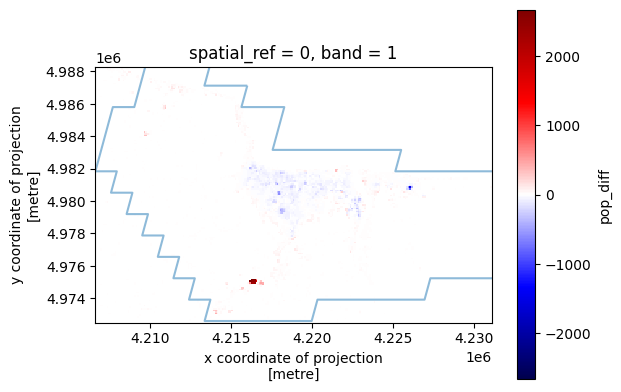

<Figure size 640x480 with 0 Axes>

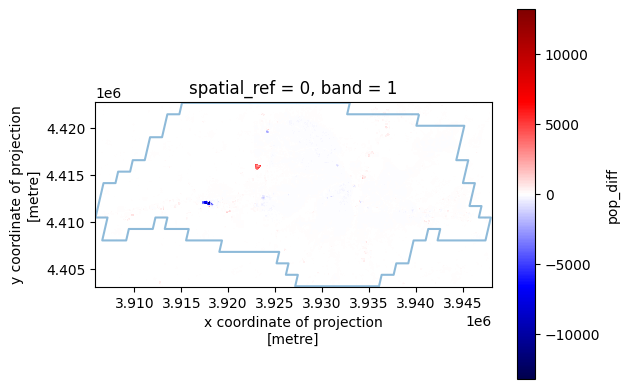

<Figure size 640x480 with 0 Axes>

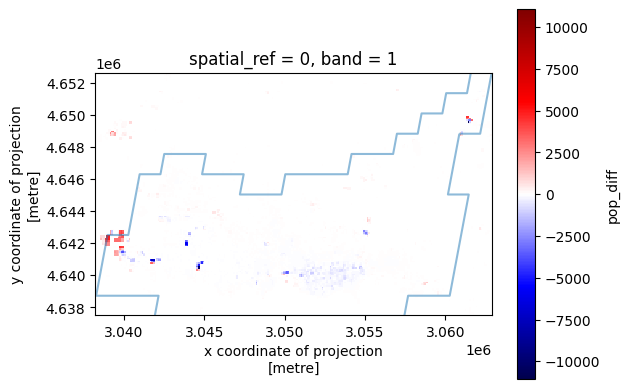

<Figure size 640x480 with 0 Axes>

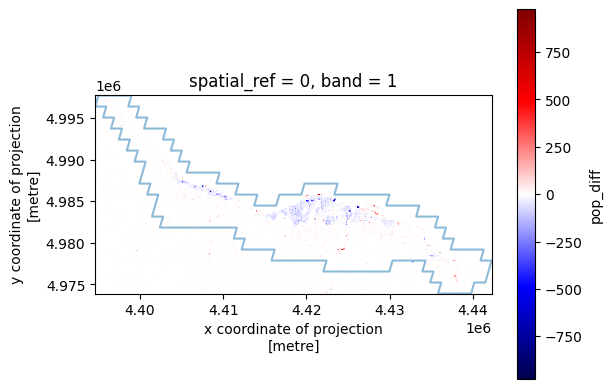

<Figure size 640x480 with 0 Axes>

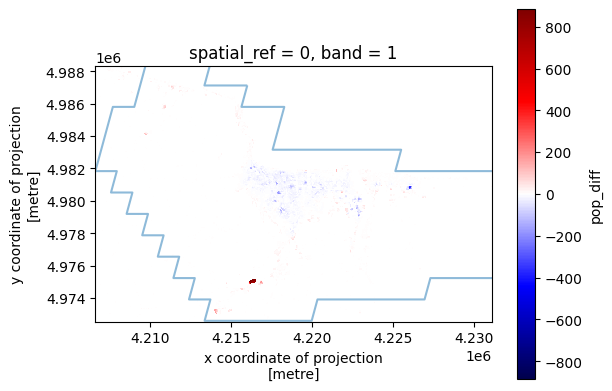

<Figure size 640x480 with 0 Axes>

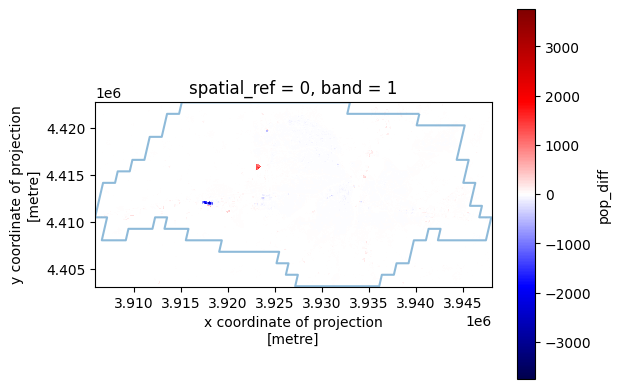

<Figure size 640x480 with 0 Axes>

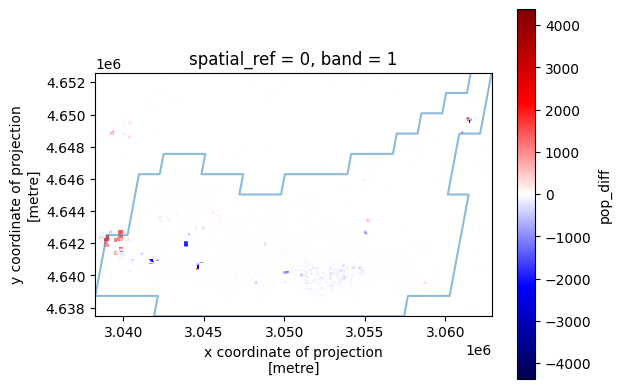

<Figure size 640x480 with 0 Axes>

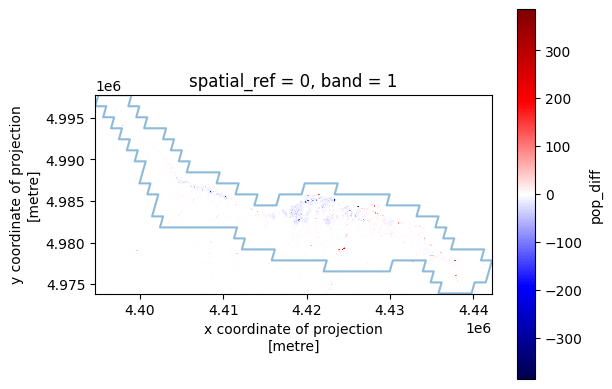

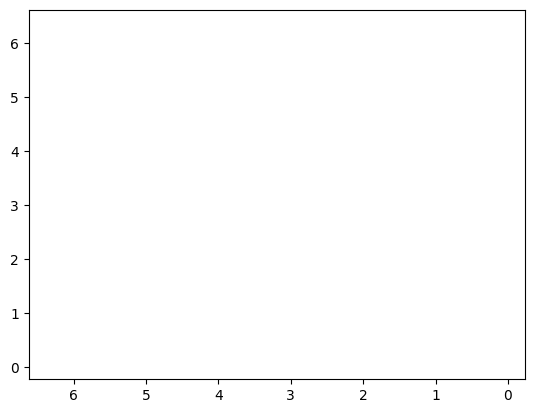

In [60]:
resolutions = [500, 250, 100, 50]
rmse = dict()
for r in resolutions:
    print(r, '\n')
    Cities = regions_from_cities(cities, r)
    for city in Cities:
        if city not in rmse:
            rmse[city]=[]
        # POP DIFF
        region = Cities[city]
        region.output = region.output.assign(pop_diff = region.output['pop_s'] - region.output['pop_v'])
        plt.figure()
        ax=region.vector['fua'].geo_df.exterior.plot(alpha=0.5)
        region.output.pop_diff.plot(ax=ax, cmap="seismic")
        # RMSE : every variable is set to a 1D array beforehand
        pop_s = np.nan_to_num(region.output['pop_s'].to_numpy()).ravel()
        pop_v = np.nan_to_num(region.output['pop_v'].to_numpy()).ravel()
        pop_rmse = np.sqrt(((pop_s - pop_v) ** 2).mean())
        rmse[city].append(pop_rmse / r)
        print(city, r, pop_rmse)

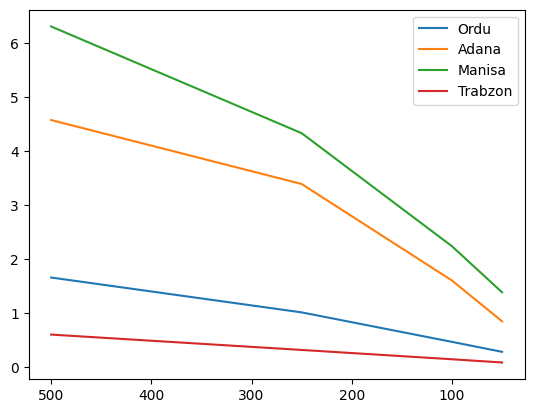

In [84]:
plt.figure()
for city in rmse:
    plt.plot(resolutions, rmse[city], label=city)
plt.legend()
plt.gca().invert_xaxis()
plt.show()


#### Relationship with NTL
We look at all cities at once, at 100 and 50 m resolutions

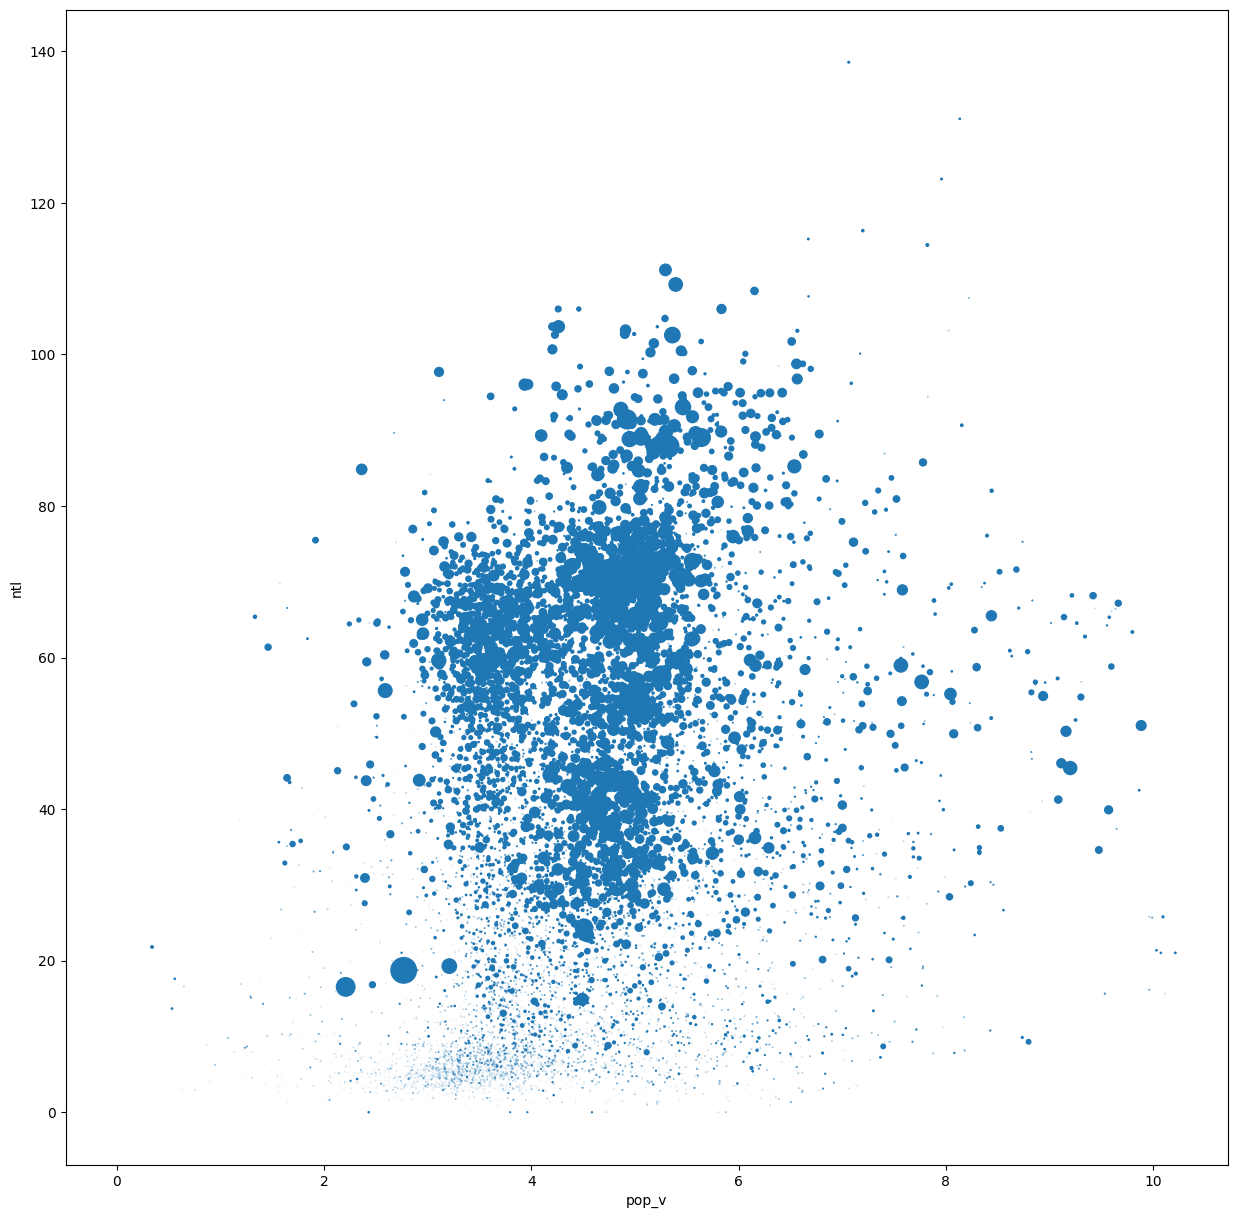

In [24]:
# NTL native resolution
resolutions = [250]
for r in resolutions:
    Cities = regions_from_cities(cities, r)
    pop_v = np.array([])
    ntl_v= np.array([])
    height_v= np.array([])
    surface_v = np.array([])

    for city in Cities:
        region = Cities[city]
        pop_v_tmp = np.nan_to_num(region.output['pop_s'].to_numpy()).ravel()
        pop_s_tmp = np.nan_to_num(region.output['pop_s'].to_numpy()).ravel()
        surface_tmp = np.nan_to_num(region.output['surface'].to_numpy()).ravel()
        ntl_tmp= np.nan_to_num(region.output['ntl'].to_numpy()).ravel()
        height_tmp= np.nan_to_num(region.output['height'].to_numpy()).ravel()

        # We need to filter the noise comming from unpopulated areas and population outlier :
        noisy_points_v = np.nonzero((pop_v_tmp > 1))[0]#&(pop_v_tmp < 1000))[0]
        pop_v = np.append(pop_v,np.take(pop_v_tmp, noisy_points_v))
        ntl_v = np.append(ntl_v,np.take(ntl_tmp, noisy_points_v))
        height_v = np.append(height_v,np.take(height_tmp, noisy_points_v))
        surface_v = np.append(surface_v,np.take(surface_tmp, noisy_points_v))
    
    # ntl_v = np.log(ntl_v)
    pop_v = np.log(pop_v)
    height_v = height_v**2
    # Plot
    plt.figure(figsize=(15,15))
    plt.xlabel('pop_v')
    plt.ylabel('ntl')
    plt.scatter(pop_v, ntl_v, s=height_v)